In [3]:
!pip install -r requirement.txt

In [31]:
from __future__ import division
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import os
import sys
from matplotlib.pyplot import imshow
import numpy as np
import cv2

In [32]:

import tensorflow as tf

In [33]:
#Importing warnings to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
#Hyperparameters
num_iterations = 2000
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6

In [35]:
#Defining a function to initialize weights and bias
def weights(layer, layer_name, model_layers):
    wb = model_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    layer_name = model_layers[0][layer][0][0][0][0]
    return W, b
#Defining conv2d layer for VGG-16
def conv2d(previous_layer, layer, layer_name, model_layers):
    W, b = weights(layer, layer_name, model_layers)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, b.size))
    return tf.nn.conv2d(previous_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
#Defining RELU + Convolution Layer together
def relu_conv2d(previous_layer, layer, layer_name, model_layers):
    return tf.nn.relu(conv2d(previous_layer, layer, layer_name, model_layers))
#Function for average Pooling 
def avg_pool(layer):
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [36]:
#Importing pretrained VGG-16
#'imagenet-vgg-verydeep-16.mat' should be in where this file exists.
def get_vgg16_model(height=IMAGE_HEIGHT, width=IMAGE_WIDTH):
    vgg = scipy.io.loadmat('./imagenet-vgg-verydeep-16.mat')
    layers = vgg['layers']
    model = {}
    model['input'] = tf.Variable(np.zeros((1, height, width, 3)), dtype = 'float32')
    model['conv1_1'] = relu_conv2d(model['input'], 0, 'conv1_1', layers)
    model['conv1_2'] = relu_conv2d(model['conv1_1'], 2, 'conv1_2', layers)
    model['avgpool1'] = avg_pool(model['conv1_2'])
    model['conv2_1'] = relu_conv2d(model['avgpool1'], 5, 'conv2_1', layers)
    model['conv2_2'] = relu_conv2d(model['conv2_1'], 7, 'conv2_2', layers)
    model['avgpool2'] = avg_pool(model['conv2_2'])
    model['conv3_1']  = relu_conv2d(model['avgpool2'], 10, 'conv3_1', layers)
    model['conv3_2']  = relu_conv2d(model['conv3_1'], 12, 'conv3_2', layers)
    model['conv3_3']  = relu_conv2d(model['conv3_2'], 14, 'conv3_3', layers)
    model['avgpool3'] = avg_pool(model['conv3_3'])
    model['conv4_1']  = relu_conv2d(model['avgpool3'], 17, 'conv4_1', layers)
    model['conv4_2']  = relu_conv2d(model['conv4_1'], 19, 'conv4_2', layers)
    model['conv4_3']  = relu_conv2d(model['conv4_2'], 21, 'conv4_3', layers)
    model['avgpool4'] = avg_pool(model['conv4_3'])
    model['conv5_1']  = relu_conv2d(model['avgpool4'], 24, 'conv5_1', layers)
    model['conv5_2']  = relu_conv2d(model['conv5_1'], 26, 'conv5_2', layers)
    model['conv5_3']  = relu_conv2d(model['conv5_2'], 28, 'conv5_3', layers)
    model['avgpool5'] = avg_pool(model['conv5_3'])
    return model

In [37]:

#Function for computing content loss 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))    
    return J_content

In [38]:

#Calculating gram matrix for a tensor
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [39]:
#Calculating style loss for a layer
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    return J_style_layer

In [40]:
#Weights of layers in calculating style loss
STYLE_LAYERS  = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [41]:
#Computing style loss for all layers that we chose and weighted above.
def compute_style_cost(model, STYLE_LAYERS):    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [42]:
#Computing Total Cost
def total_cost(J_content, J_style, alpha = 20, beta = 30):
    J = alpha * J_content + beta * J_style
    return J

In [43]:
# Reset the graph
tf.reset_default_graph()

#Start a session
sess = tf.InteractiveSession()

In [44]:

#Reshaping and normalizing image
def reshape_and_normalize_image(image):    
    image = np.reshape(image, ((1,) + image.shape))
    image = image - np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

In [54]:
#Reading content image & resizing
content_image = imageio.imread('./my.jfif')
content_image = cv2.resize(content_image, (IMAGE_WIDTH,IMAGE_HEIGHT))


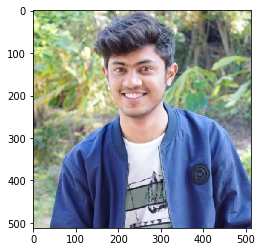

In [55]:
plt.imshow(content_image)

In [56]:
#Reshaping
content_image = reshape_and_normalize_image(content_image)

In [57]:
#Reading style image & resizing
style_image = imageio.imread('./style_image.jpg')
style_image = cv2.resize(style_image, (IMAGE_WIDTH,IMAGE_HEIGHT))

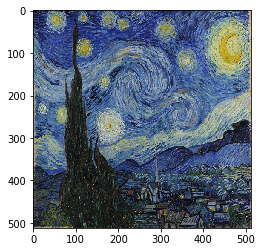

In [58]:
plt.imshow(style_image)

In [59]:
#Reshaping
style_image = reshape_and_normalize_image(style_image)

In [60]:
#Function for a noise image
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):    
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)    
    return input_image

In [61]:
#Generating a noise image
generated_image = generate_noise_image(content_image)

In [62]:
#Feeding our content image into VGG-16
model = get_vgg16_model()
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out


In [63]:
#Computing content loss between Content Image and Generated Image
J_content = compute_content_cost(a_C, a_G)

In [64]:
#Feeding our style image into VGG-16
sess.run(model['input'].assign(style_image))

#Computing style loss between Content Image and Generated Image
J_style = compute_style_cost(model, STYLE_LAYERS)

In [65]:

#Assigning weights to content and style images; alpha for content image. beta for Style Image.
J = total_cost(J_content, J_style, alpha = 20, beta = 30)

In [66]:
#Defining optimizer.
optimizer = tf.train.AdamOptimizer(2.0)

#Defining what to minimize.
train_step = optimizer.minimize(J)

W0710 21:50:19.101903 21160 deprecation.py:323] From c:\python36x64\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
with tf.Session() as sess:
    
    # Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    #Feeding our generated image into VGG-16
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
    
        #Running what to minimize.
        sess.run(train_step)
        
        #Computing the generated image
        generated_image = sess.run(model['input'])

        #Print every 50 iteration.
        if i % 50 == 0:
            #Computing total, content and style loss.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            #print("Iteration " + str(i) + " :", " total cost = " + str(Jt)," content cost = " + str(Jc)," style cost = " + str(Js))
            #print()
            
            #image = np.clip(generated_image[0], 0, 255).astype('uint8')
            image = generated_image[0]
            output_file = 'temp_output_{}.jpg'.format(i)
            #Saving the picture
            imageio.imwrite(output_file, image)
    image = generated_image[0]
    #Save last generated image
    plt.imshow(image)
    imageio.imwrite('generated_image.jpg', image)
    
    print("Finished")

W0710 21:50:51.574692 21160 util.py:59] Lossy conversion from float32 to uint8. Range [-61.8255729675293, 74.389404296875]. Convert image to uint8 prior to saving to suppress this warning.
W0710 21:55:48.137896 21160 util.py:59] Lossy conversion from float32 to uint8. Range [-146.69256591796875, 138.6825714111328]. Convert image to uint8 prior to saving to suppress this warning.
W0710 22:00:35.587073 21160 util.py:59] Lossy conversion from float32 to uint8. Range [-171.84478759765625, 141.24710083007812]. Convert image to uint8 prior to saving to suppress this warning.
W0710 22:04:56.750387 21160 util.py:59] Lossy conversion from float32 to uint8. Range [-202.3359832763672, 169.47723388671875]. Convert image to uint8 prior to saving to suppress this warning.
